In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

### Input Data and Dimensions

In [2]:
from sklearn.preprocessing import normalize

#Input data
dir = 'final_10to35_4/'
data = np.load(dir+'vibli_feature.npy')
data = normalize(data)
data = torch.from_numpy(data)

#Input data dimensions
n_samples = data.size()[0]
n_features = data.size()[1]
print(data.size())
#Latent dimensions
latent_dim = 2

torch.Size([867, 180])


### Construct the model

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, n_features, n_samples, latent_dim):
        super().__init__()
        #encoder
        self.img_2hid1 = nn.Linear(n_features, n_samples)
        self.img_2hid2 = nn.Linear(n_samples, n_samples)
        self.hid_2z = nn.Linear(n_samples, latent_dim)
        
        #decoder
        self.z_2hid = nn.Linear(latent_dim, n_samples)
        self.hid_2img = nn.Linear(n_samples, n_features)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        h1 = self.relu(self.img_2hid1(x))
        h2 = self.relu(self.img_2hid2(h1))
        z = self.hid_2z(h2)
        
        return z
    
    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))
    
    def forward(self, x):
        z = self.encode(x)
        
        x_reconstructed = self.decode(z)
        
        return x_reconstructed

In [4]:
##A randn check of the model.
if __name__ == "__main__":
    x = data.float()
    ae = AutoEncoder(n_features, n_samples, latent_dim)
    x_reconstructed = ae(x)
    print(x_reconstructed.shape)
    print(x_reconstructed)

torch.Size([867, 180])
tensor([[0.4940, 0.4982, 0.5115,  ..., 0.4759, 0.5807, 0.5848],
        [0.4941, 0.4983, 0.5115,  ..., 0.4759, 0.5807, 0.5848],
        [0.4940, 0.4981, 0.5116,  ..., 0.4760, 0.5805, 0.5848],
        ...,
        [0.4940, 0.4984, 0.5115,  ..., 0.4759, 0.5809, 0.5849],
        [0.4941, 0.4984, 0.5115,  ..., 0.4759, 0.5808, 0.5849],
        [0.4948, 0.4987, 0.5115,  ..., 0.4761, 0.5803, 0.5847]],
       grad_fn=<SigmoidBackward0>)


### Train the model

In [5]:
import torch
import torchvision.datasets as datasets #Standard datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [7]:
#Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 10
BATCH_SIZE = 100
LR_RATE = 1e-4 #Karpathy constant, too large
train_loader = DataLoader(dataset=x, batch_size=BATCH_SIZE, shuffle=True)
print(next(iter(train_loader)))
#train_features, train_labels = next(iter(train_loader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
loss_fn = nn.BCELoss(reduction='mean') #MSE_loss, BCELoss y_i * (log())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [8]:
def train(model):
    losses = []
    for epoch in range(NUM_EPOCHS):
        loop = tqdm(enumerate(train_loader)) #get progress bar
        for i, x in loop:
            #forward pass
            x = x.to(DEVICE).view(x.shape[0], n_features) #view without a copy, reshape
            x_reconstructed = model(x)
            #Compute loss
            reconstruction_loss = loss_fn(x_reconstructed, x)        
            #Backprop
            loss = reconstruction_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
    return model, losses

In [9]:
loss_lat = []
step = 2
for latent_dim in range(2, 51, step):
    print('LATENT DIMENSIONS: '+str(latent_dim))
    model = AutoEncoder(n_features, n_samples, latent_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
    model_train, losses = train(model)
    loss_lat.append(losses)

LATENT DIMENSIONS: 2


9it [00:00, 51.82it/s, loss=0.631]
9it [00:00, 64.79it/s, loss=0.565]
9it [00:00, 65.81it/s, loss=0.493]
9it [00:00, 64.36it/s, loss=0.405]
9it [00:00, 66.30it/s, loss=0.291]
9it [00:00, 61.97it/s, loss=0.186]
9it [00:00, 62.82it/s, loss=0.136]
9it [00:00, 64.70it/s, loss=0.127]
9it [00:00, 63.19it/s, loss=0.117]
9it [00:00, 64.34it/s, loss=0.108]


LATENT DIMENSIONS: 4


9it [00:00, 65.43it/s, loss=0.66] 
9it [00:00, 64.20it/s, loss=0.611]
9it [00:00, 64.04it/s, loss=0.556]
9it [00:00, 64.20it/s, loss=0.476]
9it [00:00, 64.94it/s, loss=0.358]
9it [00:00, 64.98it/s, loss=0.226]
9it [00:00, 66.05it/s, loss=0.149]
9it [00:00, 62.66it/s, loss=0.133]
9it [00:00, 64.91it/s, loss=0.12] 
9it [00:00, 59.54it/s, loss=0.12] 


LATENT DIMENSIONS: 6


9it [00:00, 65.93it/s, loss=0.655]
9it [00:00, 66.63it/s, loss=0.614]
9it [00:00, 64.30it/s, loss=0.566]
9it [00:00, 63.72it/s, loss=0.494]
9it [00:00, 66.07it/s, loss=0.374]
9it [00:00, 66.07it/s, loss=0.232]
9it [00:00, 67.19it/s, loss=0.146]
9it [00:00, 65.71it/s, loss=0.126]
9it [00:00, 64.70it/s, loss=0.128]
9it [00:00, 64.97it/s, loss=0.117]


LATENT DIMENSIONS: 8


9it [00:00, 62.79it/s, loss=0.665]
9it [00:00, 62.91it/s, loss=0.629]
9it [00:00, 61.84it/s, loss=0.586]
9it [00:00, 65.05it/s, loss=0.517]
9it [00:00, 62.91it/s, loss=0.399]
9it [00:00, 63.15it/s, loss=0.251]
9it [00:00, 63.10it/s, loss=0.152]
9it [00:00, 64.86it/s, loss=0.129]
9it [00:00, 61.65it/s, loss=0.125]
9it [00:00, 64.70it/s, loss=0.118]


LATENT DIMENSIONS: 10


9it [00:00, 64.09it/s, loss=0.665]
9it [00:00, 63.00it/s, loss=0.632]
9it [00:00, 64.63it/s, loss=0.59] 
9it [00:00, 64.39it/s, loss=0.52] 
9it [00:00, 65.26it/s, loss=0.401]
9it [00:00, 60.48it/s, loss=0.251]
9it [00:00, 63.06it/s, loss=0.157]
9it [00:00, 65.77it/s, loss=0.134]
9it [00:00, 65.03it/s, loss=0.121]
9it [00:00, 65.09it/s, loss=0.117]


LATENT DIMENSIONS: 12


9it [00:00, 62.19it/s, loss=0.671]
9it [00:00, 57.26it/s, loss=0.643]
9it [00:00, 59.46it/s, loss=0.608]
9it [00:00, 58.95it/s, loss=0.552]
9it [00:00, 58.14it/s, loss=0.45] 
9it [00:00, 57.86it/s, loss=0.306]
9it [00:00, 60.23it/s, loss=0.177]
9it [00:00, 56.01it/s, loss=0.136]
9it [00:00, 62.66it/s, loss=0.133]
9it [00:00, 60.34it/s, loss=0.122]


LATENT DIMENSIONS: 14


9it [00:00, 64.48it/s, loss=0.674]
9it [00:00, 60.13it/s, loss=0.645]
9it [00:00, 61.11it/s, loss=0.606]
9it [00:00, 59.53it/s, loss=0.541]
9it [00:00, 59.94it/s, loss=0.425]
9it [00:00, 60.95it/s, loss=0.266]
9it [00:00, 62.03it/s, loss=0.156]
9it [00:00, 59.06it/s, loss=0.133]
9it [00:00, 59.86it/s, loss=0.129]
9it [00:00, 61.24it/s, loss=0.121]


LATENT DIMENSIONS: 16


9it [00:00, 59.32it/s, loss=0.673]
9it [00:00, 60.39it/s, loss=0.647]
9it [00:00, 60.62it/s, loss=0.61] 
9it [00:00, 61.71it/s, loss=0.542]
9it [00:00, 57.03it/s, loss=0.42] 
9it [00:00, 61.33it/s, loss=0.256]
9it [00:00, 58.96it/s, loss=0.153]
9it [00:00, 59.40it/s, loss=0.131]
9it [00:00, 61.47it/s, loss=0.127]
9it [00:00, 60.53it/s, loss=0.118]


LATENT DIMENSIONS: 18


9it [00:00, 57.70it/s, loss=0.67] 
9it [00:00, 57.95it/s, loss=0.644]
9it [00:00, 54.14it/s, loss=0.607]
9it [00:00, 60.43it/s, loss=0.541]
9it [00:00, 56.89it/s, loss=0.42] 
9it [00:00, 59.79it/s, loss=0.258]
9it [00:00, 58.82it/s, loss=0.149]
9it [00:00, 61.49it/s, loss=0.138]
9it [00:00, 61.29it/s, loss=0.131]
9it [00:00, 60.88it/s, loss=0.11] 


LATENT DIMENSIONS: 20


9it [00:00, 62.29it/s, loss=0.672]
9it [00:00, 61.40it/s, loss=0.647]
9it [00:00, 57.56it/s, loss=0.613]
9it [00:00, 63.86it/s, loss=0.554]
9it [00:00, 64.19it/s, loss=0.44] 
9it [00:00, 66.48it/s, loss=0.277]
9it [00:00, 63.76it/s, loss=0.157]
9it [00:00, 64.09it/s, loss=0.124]
9it [00:00, 63.48it/s, loss=0.131]
9it [00:00, 60.70it/s, loss=0.112]


LATENT DIMENSIONS: 22


9it [00:00, 60.62it/s, loss=0.674]
9it [00:00, 60.38it/s, loss=0.648]
9it [00:00, 60.72it/s, loss=0.61] 
9it [00:00, 56.29it/s, loss=0.539]
9it [00:00, 62.79it/s, loss=0.412]
9it [00:00, 58.82it/s, loss=0.239]
9it [00:00, 60.51it/s, loss=0.147]
9it [00:00, 61.38it/s, loss=0.139]
9it [00:00, 61.99it/s, loss=0.121]
9it [00:00, 61.99it/s, loss=0.113]


LATENT DIMENSIONS: 24


9it [00:00, 62.68it/s, loss=0.674]
9it [00:00, 61.44it/s, loss=0.65] 
9it [00:00, 63.75it/s, loss=0.615]
9it [00:00, 62.77it/s, loss=0.549]
9it [00:00, 62.96it/s, loss=0.426]
9it [00:00, 59.96it/s, loss=0.256]
9it [00:00, 59.61it/s, loss=0.147]
9it [00:00, 60.43it/s, loss=0.134]
9it [00:00, 61.55it/s, loss=0.118]
9it [00:00, 59.81it/s, loss=0.115]


LATENT DIMENSIONS: 26


9it [00:00, 59.99it/s, loss=0.676]
9it [00:00, 61.55it/s, loss=0.653]
9it [00:00, 61.23it/s, loss=0.621]
9it [00:00, 63.26it/s, loss=0.558]
9it [00:00, 60.57it/s, loss=0.436]
9it [00:00, 62.73it/s, loss=0.269]
9it [00:00, 62.69it/s, loss=0.156]
9it [00:00, 62.80it/s, loss=0.136]
9it [00:00, 62.57it/s, loss=0.127]
9it [00:00, 61.01it/s, loss=0.119]


LATENT DIMENSIONS: 28


9it [00:00, 63.60it/s, loss=0.674]
9it [00:00, 63.69it/s, loss=0.649]
9it [00:00, 63.45it/s, loss=0.61] 
9it [00:00, 63.03it/s, loss=0.535]
9it [00:00, 62.92it/s, loss=0.396]
9it [00:00, 63.75it/s, loss=0.223]
9it [00:00, 58.68it/s, loss=0.138]
9it [00:00, 63.64it/s, loss=0.133]
9it [00:00, 61.56it/s, loss=0.12] 
9it [00:00, 64.22it/s, loss=0.119]


LATENT DIMENSIONS: 30


9it [00:00, 62.50it/s, loss=0.674]
9it [00:00, 63.25it/s, loss=0.65] 
9it [00:00, 60.24it/s, loss=0.613]
9it [00:00, 61.13it/s, loss=0.542]
9it [00:00, 61.34it/s, loss=0.41] 
9it [00:00, 60.31it/s, loss=0.236]
9it [00:00, 60.86it/s, loss=0.141]
9it [00:00, 60.42it/s, loss=0.137]
9it [00:00, 60.77it/s, loss=0.122]
9it [00:00, 61.17it/s, loss=0.114]


LATENT DIMENSIONS: 32


9it [00:00, 62.59it/s, loss=0.676]
9it [00:00, 60.59it/s, loss=0.654]
9it [00:00, 60.50it/s, loss=0.62] 
9it [00:00, 60.10it/s, loss=0.554]
9it [00:00, 56.84it/s, loss=0.426]
9it [00:00, 59.47it/s, loss=0.253]
9it [00:00, 57.23it/s, loss=0.145]
9it [00:00, 57.64it/s, loss=0.128]
9it [00:00, 57.64it/s, loss=0.122]
9it [00:00, 59.52it/s, loss=0.117]


LATENT DIMENSIONS: 34


9it [00:00, 60.24it/s, loss=0.678]
9it [00:00, 63.29it/s, loss=0.659]
9it [00:00, 57.10it/s, loss=0.628]
9it [00:00, 62.67it/s, loss=0.57] 
9it [00:00, 59.78it/s, loss=0.45] 
9it [00:00, 55.74it/s, loss=0.274]
9it [00:00, 54.67it/s, loss=0.152]
9it [00:00, 53.91it/s, loss=0.136]
9it [00:00, 60.18it/s, loss=0.129]
9it [00:00, 57.13it/s, loss=0.115]


LATENT DIMENSIONS: 36


9it [00:00, 59.96it/s, loss=0.677]
9it [00:00, 50.68it/s, loss=0.656]
9it [00:00, 60.62it/s, loss=0.624]
9it [00:00, 61.72it/s, loss=0.56] 
9it [00:00, 62.31it/s, loss=0.437]
9it [00:00, 60.68it/s, loss=0.264]
9it [00:00, 60.10it/s, loss=0.147]
9it [00:00, 56.07it/s, loss=0.121]
9it [00:00, 58.73it/s, loss=0.126]
9it [00:00, 61.58it/s, loss=0.117]


LATENT DIMENSIONS: 38


9it [00:00, 57.25it/s, loss=0.675]
9it [00:00, 58.50it/s, loss=0.652]
9it [00:00, 59.67it/s, loss=0.613]
9it [00:00, 60.45it/s, loss=0.533]
9it [00:00, 61.34it/s, loss=0.38] 
9it [00:00, 56.89it/s, loss=0.208]
9it [00:00, 59.71it/s, loss=0.136]
9it [00:00, 57.81it/s, loss=0.131]
9it [00:00, 58.30it/s, loss=0.121]
9it [00:00, 59.12it/s, loss=0.112]


LATENT DIMENSIONS: 40


9it [00:00, 58.44it/s, loss=0.679]
9it [00:00, 60.43it/s, loss=0.658]
9it [00:00, 59.37it/s, loss=0.624]
9it [00:00, 59.38it/s, loss=0.553]
9it [00:00, 57.23it/s, loss=0.414]
9it [00:00, 54.82it/s, loss=0.23] 
9it [00:00, 57.47it/s, loss=0.135]
9it [00:00, 58.02it/s, loss=0.13] 
9it [00:00, 53.30it/s, loss=0.123]
9it [00:00, 58.71it/s, loss=0.115]


LATENT DIMENSIONS: 42


9it [00:00, 59.44it/s, loss=0.677]
9it [00:00, 60.63it/s, loss=0.658]
9it [00:00, 60.07it/s, loss=0.627]
9it [00:00, 59.50it/s, loss=0.56] 
9it [00:00, 59.76it/s, loss=0.424]
9it [00:00, 61.76it/s, loss=0.241]
9it [00:00, 59.17it/s, loss=0.142]
9it [00:00, 60.03it/s, loss=0.131]
9it [00:00, 60.42it/s, loss=0.126]
9it [00:00, 60.77it/s, loss=0.11] 


LATENT DIMENSIONS: 44


9it [00:00, 64.08it/s, loss=0.678]
9it [00:00, 64.28it/s, loss=0.657]
9it [00:00, 64.18it/s, loss=0.621]
9it [00:00, 63.21it/s, loss=0.544]
9it [00:00, 61.09it/s, loss=0.393]
9it [00:00, 62.84it/s, loss=0.21] 
9it [00:00, 61.07it/s, loss=0.132]
9it [00:00, 62.70it/s, loss=0.139]
9it [00:00, 62.92it/s, loss=0.118]
9it [00:00, 63.97it/s, loss=0.113]


LATENT DIMENSIONS: 46


9it [00:00, 59.76it/s, loss=0.678]
9it [00:00, 61.54it/s, loss=0.658]
9it [00:00, 62.47it/s, loss=0.622]
9it [00:00, 62.32it/s, loss=0.547]
9it [00:00, 61.17it/s, loss=0.398]
9it [00:00, 60.38it/s, loss=0.215]
9it [00:00, 60.75it/s, loss=0.131]
9it [00:00, 60.42it/s, loss=0.135]
9it [00:00, 61.52it/s, loss=0.121]
9it [00:00, 56.45it/s, loss=0.113]


LATENT DIMENSIONS: 48


9it [00:00, 61.83it/s, loss=0.679]
9it [00:00, 59.37it/s, loss=0.658]
9it [00:00, 57.10it/s, loss=0.623]
9it [00:00, 56.94it/s, loss=0.548]
9it [00:00, 55.19it/s, loss=0.399]
9it [00:00, 56.25it/s, loss=0.212]
9it [00:00, 58.03it/s, loss=0.135]
9it [00:00, 58.06it/s, loss=0.124]
9it [00:00, 59.67it/s, loss=0.13] 
9it [00:00, 59.71it/s, loss=0.116]


LATENT DIMENSIONS: 50


9it [00:00, 62.66it/s, loss=0.678]
9it [00:00, 62.50it/s, loss=0.66] 
9it [00:00, 60.10it/s, loss=0.629]
9it [00:00, 60.42it/s, loss=0.558]
9it [00:00, 60.85it/s, loss=0.413]
9it [00:00, 60.49it/s, loss=0.226]
9it [00:00, 61.92it/s, loss=0.138]
9it [00:00, 60.13it/s, loss=0.136]
9it [00:00, 61.15it/s, loss=0.123]
9it [00:00, 59.23it/s, loss=0.107]


In [11]:
fs = 13

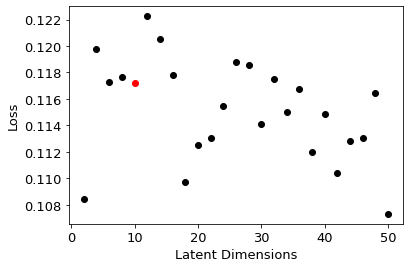

In [13]:
import matplotlib.pyplot as plt

for dim, losses in enumerate(loss_lat):
    if dim*step+2 == 10:
        color ='r'
    else:
        color = 'k'
    #plt.scatter(dim*step+2, losses[-1]/(BATCH_SIZE*n_features), color=color)
    plt.scatter(dim*step+2, losses[-1], color=color)
    plt.xlabel('Latent Dimensions', fontsize=fs)
    plt.ylabel('Loss', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7')])

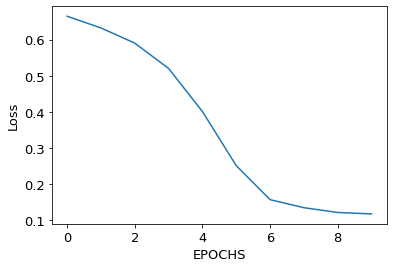

In [14]:
DIM = 10
actual_dim = int((DIM-2)/step)

#plt.plot(np.array(loss_lat[actual_dim])/(BATCH_SIZE*n_features))
plt.plot(np.array(loss_lat[actual_dim]))
plt.xlabel('EPOCHS', fontsize=fs)
plt.ylabel('Loss', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

In [12]:
latent_dim = 10
model = AutoEncoder(n_features, n_samples, latent_dim).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
model_train, losses = train(model)

9it [00:00, 63.00it/s, loss=8.01e+3]
9it [00:00, 63.02it/s, loss=7.58e+3]
9it [00:00, 63.42it/s, loss=7.01e+3]
9it [00:00, 62.66it/s, loss=6.09e+3]
9it [00:00, 73.11it/s, loss=4.58e+3]
9it [00:00, 71.36it/s, loss=2.84e+3]
9it [00:00, 66.92it/s, loss=1.8e+3] 
9it [00:00, 70.71it/s, loss=1.61e+3]
9it [00:00, 69.77it/s, loss=1.4e+3] 
9it [00:00, 70.82it/s, loss=1.39e+3]


### Save data

In [13]:
import matplotlib.pyplot as plt

model.eval()

def plot_latent(model, data, NUM_EPOCHS=NUM_EPOCHS):
    z = model.encode(x.to(DEVICE))
    plt.scatter(z[:,0], z[:,0])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
            
    return z

torch.Size([867, 10])


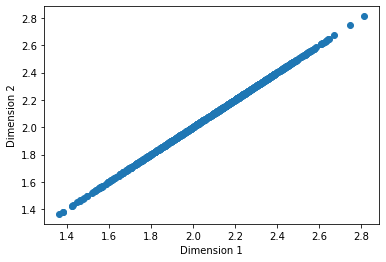

In [14]:
with torch.no_grad():
    z = plot_latent(model_train, train_loader)
    print(z.size())
    data_reduced = z.numpy()

In [15]:
np.save('lidos_f_ae', data_reduced)